In [34]:
#import relevant libraries
import numpy as np
import emcee
import pandas as pd
import matplotlib.pyplot as plt
import corner


In [30]:
#set iPTF16hvw redshit and B band max
z_16hvw = .03663

MJD_max_16hvw = 57714.40

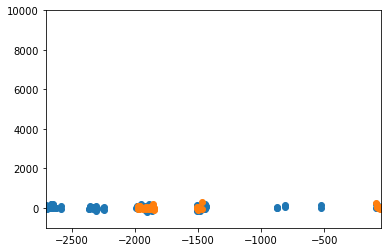

31.343230500000008

In [31]:
#import the data
g = pd.read_csv('../Data/16hvw_photometry/16hvw_g_forced_flux.txt', sep=" " , header=None)
R = pd.read_csv('../Data/16hvw_photometry/16hvw_R_forced_flux.txt', sep=" " , header=None)

#convert to MJD
g[0] = g[0] - 2400000.5
R[0] = R[0] - 2400000.5

#convert times relative to SN max light in restframe
g[0] = g[0] - MJD_max_16hvw
R[0] = R[0] - MJD_max_16hvw

#Set column names 
g.columns = ['phase' , 'Flux' ,'Fluxerr']
R.columns =  ['phase' , 'Flux' ,'Fluxerr']


#get rid of bad data
R_bad_indices = np.where(np.logical_or(R['Fluxerr']< 0, R['Flux'] == 99999999.0))
g_bad_indices = np.where(np.logical_or(g['Fluxerr']< 0, g['Flux'] == 99999999.0))

R.drop(index=R_bad_indices[0], inplace=True)
g.drop(index=g_bad_indices[0], inplace=True)

#plot data 
plt.errorbar(R['phase'],  R['Flux'], yerr=R['Fluxerr'], fmt='o' )
plt.errorbar(g['phase'] , g['Flux'], yerr=g['Fluxerr'], fmt ='o')
plt.xlim([np.min(R['phase']), -50])
plt.ylim([-1000,10000])
plt.show()
np.mean(R['Flux'][0:100])

# likelihood function

# <center> $\prod_{i} \frac{1}{\sqrt{\pi ( \sigma_{i}^{2} + \sigma_{0}^{2}})} exp\bigg(\frac{-(y_{i} - (a + b(t-t_{0})^{\alpha}))}{\sigma_{i}^{2} + \sigma_{0}^{2}}\bigg) $
</centering>

# <center>$\prod_{i} \frac{1}{\sqrt{\pi ( \sigma_{i}^{2} + \sigma_{0}^{2} })} exp\bigg(\frac{-(y_{i} - a )}{\sigma_{i}^{2} + \sigma_{0}^{2}}\bigg)$
    
   

In [37]:
#Define the log likelihood
def lnlikelihood(theta, f, t, f_err):
    a, b, t_0, alpha, sig_0 = theta
    ln_l = 0
    for i in range(len(t)):
        if(t[i] < t_0):
            model = a
        elif(t[i] > t_0):
            model = a + (b*((t[i] - t_0)**alpha))
        ln_l += np.log(1. / np.sqrt(2*np.pi * (sig_0**2 + f_err[i]**2))) - ((f[i] - model)**2 / (2 * (sig_0**2 + f_err[i]**2)))
    return -ln_l

#Define priors on parameters  
def lnprior(theta):
    a, b, t_0, alpha, sig_0 = theta
    if(-20 < t_0 < -10 and 0 < alpha < 5 and sig_0 > 0 and -100 < a < 100,  0 < b < 100):
        return 0.0
    return -np.inf
   
def posterior(theta, f, t, f_err):
    prior = lnprior(theta)
    lnl = lnlikelihood(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(prior):
        return -np.inf
    return lnl + prior
    
   

In [38]:
#initial guess on parameters
guess_0 = [30 , 1 ,-16, 2, 100]



In [39]:
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2, 1e-2, 1e-2]
ndim = len(guess_0)
ncores=6
pos = [guess_0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior, args=(np.array(R['Flux']), np.array(R['phase']) , np.array(R['Fluxerr'])), threads = ncores)

nsamples = 6000
foo = sampler.run_mcmc(pos, nsamples)


/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in double_scalars
/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in double_scalars
/Users/ethanmarx/anaconda/lib/python2.7/site-packages/ip

In [9]:
# set a "burn-in" limit
nburn = 200
alpha_samples = np.array(sampler.chain[:,nburn:,3]).flatten()
t_0_samples = np.array(sampler.chain[:,nburn:,2]).flatten()

#print the results taking 1-sigma confidence intervals
samples = np.vstack([t_0_samples, alpha_samples]).T
t_0_mc, alpha_mc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      t_0 = {:.4f} +{:.4f} -{:.4f}\n \
      alpha = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(t_0_mc[0], t_0_mc[1], t_0_mc[2], alpha_mc[0], alpha_mc[1], alpha_mc[2]))

emcee results with 1-sigma uncertainties
       t_0 = -19.0968 +2.6455 -0.8919
       alpha = 4.8477 +0.1221 -0.1975



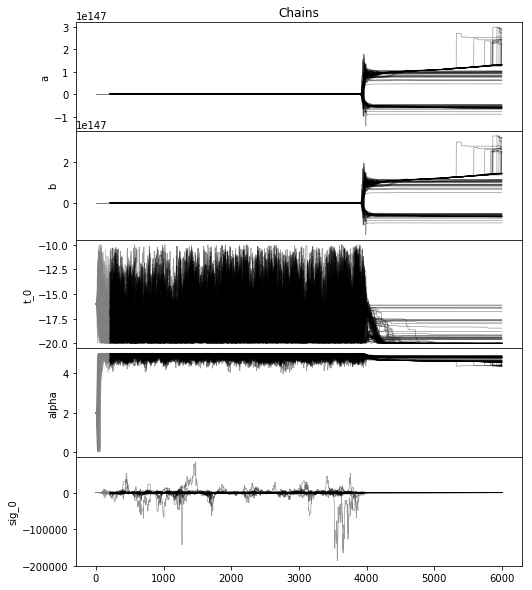

In [12]:
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

paramsNames=['a', 
           'b', 't_0', 'alpha', 'sig_0']

axC = plotChains(sampler, nburn, paramsNames)
plt.savefig('Chains')
plt.show()


In [35]:
#corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles)

makeCorner(sampler, nburn, paramsNames)

array([[[ 3.00121286e+001,  1.04427543e+000, -1.60210762e+001,
          1.99136563e+000,  9.99888553e+001],
        [ 3.00135044e+001,  1.04554764e+000, -1.60209029e+001,
          1.99162315e+000,  9.99880211e+001],
        [ 3.00082353e+001,  1.03319673e+000, -1.60138661e+001,
          1.99716397e+000,  9.99903647e+001],
        ...,
        [-6.41352900e+147, -3.63391659e+147, -1.99815163e+001,
          4.30017966e+000,  1.87535093e+000],
        [-6.41352900e+147, -3.63391659e+147, -1.99815163e+001,
          4.30017966e+000,  1.87535093e+000],
        [-6.41352900e+147, -3.63391659e+147, -1.99815163e+001,
          4.30017966e+000,  1.87535093e+000]],

       [[ 2.99833399e+001,  1.00470436e+000, -1.59830522e+001,
          2.00805373e+000,  1.00011565e+002],
        [ 2.99864488e+001,  1.00126708e+000, -1.59860220e+001,
          2.00391745e+000,  1.00007500e+002],
        [ 2.99864723e+001,  1.00120770e+000, -1.59857509e+001,
          2.00400772e+000,  1.00007630e+002],
    